In [1]:
import matplotlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
from transformers import  BertTokenizer,DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import  AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn
from sklearn.model_selection import train_test_split
import os
import sys
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
%reload_ext autoreload
%autoreload 1
%aimport DataFun
%aimport LSTM_pytorch
from DataFun import plot_error,plot_data,rmse,MSE,R2
import LSTM_pytorch as LSTM_pytorch
NUM_EPOCHS=30

In [2]:
def train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim):
    (input_dim, train_dataset, train_loader, val_dataset,
     val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(df=df,
                                                                  keys=keys,
                                                                  batch_size=batch_size,
                                                                  targets=targets,
                                                                  output_dim=output_dim,
                                                                  window_size=seq_dim)
    training_record=[]
    train_l=0
    val_l=0
    for i in range(100):
        model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = 50)
        training_record.append([model,train_loss,val_loss])
        train_l=+train_loss[-1]
        val_l=+val_loss[-1]
    train_l=train_l/100
    val_l=val_l/100
    print(f"single layer LSTM train_l: {train_l}, val_l: {val_l}" )
    return training_record,test_dataset

def test_LSTM(model_name,test_dataset,training_record,total_record):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=1,
                                              shuffle=True)
    prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

    # fig, axs = plt.subplots(5,2)
    # #plt.xlim(0, 0.8)
    # fig.set_size_inches(18.5, 14.5)
    for index,record in enumerate(training_record):
        model,_,_=record
        predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
        prediction_record=prediction_record.append({"model_name":model_name,
                                                    "model":index,
                                                    "MSE":mse.item(),
                                                    "RMSE":rmse,"R2":r}, ignore_index=True)
        
    
    total_record = total_record.append(prediction_record,ignore_index=True)
   
    return total_record,prediction_record

def total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record):
    index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
    index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
    modle_min_mse,_,_=training_record[index_min_mse]
    model_max_r2,_,_=training_record[index_max_r]
    scaler=MinMaxScaler()
    (input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=df,
                                                                  keys=keys,
                                                                  batch_size=batch_size,
                                                                  targets=targets,
                                                                  output_dim=output_dim,
                                                                  window_size=seq_dim)
    #LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
    data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                              batch_size=1,
                                              shuffle=True)
    predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
    print('MSE = {}'.format(mse))
    print('RMSE = {}'.format(rmse))
    print('R-Squared Score = {}'.format(r))

    plot_data(actual,predicted)
 
    score="MSE"
    total_model_record=total_model_record.append({"model":model_name,"score":score,"sentiment_method": "no sentiment",
                          "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)
    return total_model_record


In [3]:
## VAR
def VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,ETH_df,keys,total_model_record):
    prediction_record=pd.DataFrame(None,columns=["model_name","model","MSE","RMSE","R2"])

    result=VAR_forecast(VAR_model_fitted1,test_dataset)
    prediction=result["price"]
    actual=test_dataset["price"]
    VAR_1_mse=DataFun.MSE(prediction,actual)
    VAR_1_R2=DataFun.R2(actual,prediction)
    VAR_1_rmse=DataFun.rmse(prediction,actual)
    prediction_record=prediction_record.append({"model_name":model_name,
                                                    "model":1,
                                                    "MSE":VAR_1_mse,
                                                    "RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)

    total_record = total_record.append(prediction_record,ignore_index=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled_train = scaler.fit_transform(ETH_df)
    ETH_df = pd.DataFrame(df_scaled_train,columns=keys)
    result=VAR_forecast(VAR_model_fitted1,ETH_df)
    prediction=result["price"]
    actual=ETH_df["price"]
    VAR_1_mse=DataFun.MSE(prediction,actual)
    VAR_1_R2=DataFun.R2(actual,prediction)
    VAR_1_rmse=DataFun.rmse(prediction,actual)
    print('MSE = {}'.format(VAR_1_mse))
    print('RMSE = {}'.format(VAR_1_rmse))
    print('R-Squared Score = {}'.format(VAR_1_R2))

    plot_data(actual,prediction)
    score="MSE"
    total_model_record=total_model_record.append({"model":model_name,"score":score,"sentiment_method": "no sentiment",
                          "MSE":VAR_1_mse,"RMSE":VAR_1_rmse,"R2":VAR_1_R2}, ignore_index=True)
    return total_record,total_model_record

## LSTM+LM


In [4]:
# LSTM strucure:
hidden_dim = 10
layer_dim = 1 # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 7
batch_size = 7

filepath = f"./data/ETH_Data.csv"
ETH_df = pd.read_csv(filepath, infer_datetime_format=True,
                         parse_dates=True)
ETH_df=ETH_df.fillna(0)
ETH_df=ETH_df[:-1]
key=['High', 'Low', 'Open', 'Close', 'Volume', 'tweets',
      'google_trends','profitability','Marketcap','price']
targets = ["price"]

direction=f'./model/baseline'
sentiment_direction=f'./data/model_dense'

single layer LSTM train_l: 1.0307881357501146e-05, val_l: 4.584023449024929e-06
MSE = 0.006232783198356628
RMSE = 0.0
R-Squared Score = 0.8578702333929067


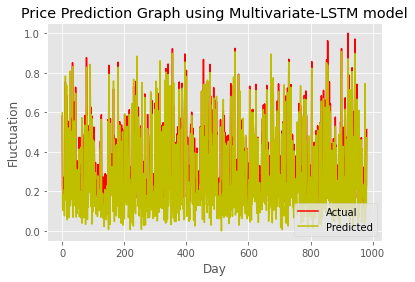

,MSE,R2,RMSE,model,score,sentiment_method
0,0.006233,0.85787,0.0,ETH_LM_2_LSTM-7,MSE,no sentiment


In [5]:
file_sentiment=f'./data/LM_dic_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('Date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['Negative','Positive']]], axis=1, join='inner')
total_record=pd.DataFrame()
num_epochs = 20

model_name="ETH_LM_2_LSTM-7"
keys=df.columns
total_model_record=pd.DataFrame()
training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)
total_model_record=model_record
total_model_record

In [6]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -81.58      -81.50   3.731e-36      -81.55
1       -106.5     -105.5*   5.438e-47     -106.1*
2       -106.5      -104.5   5.539e-47      -105.7
3       -106.6      -103.7   5.031e-47      -105.5
4       -106.5      -102.6   5.354e-47      -105.0
5       -106.6      -101.7   5.343e-47      -104.7
6      -106.8*      -101.0  4.169e-47*      -104.6
7       -106.8      -99.99   4.346e-47      -104.1
8       -106.7      -98.97   4.659e-47      -103.7
9       -106.8      -98.09   4.377e-47      -103.4
10      -106.8      -97.14   4.383e-47      -103.1
--------------------------------------------------


MSE = 0.0004614563056348642
RMSE = 0.021481534061487884
R-Squared Score = 0.9892123841052096


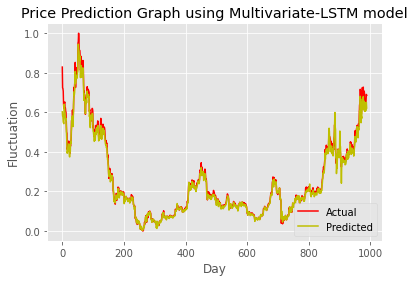

In [7]:
VAR_model_fitted1=VAR_model.fit(6)
df=df
keys=df.columns
model_name="VAR_LM"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+BERT_base_cased


single layer LSTM train_l: 1.3997376686809046e-05, val_l: 6.3703861535643426e-06
MSE = 0.005111163482069969
RMSE = 0.0
R-Squared Score = 0.8810727027183596


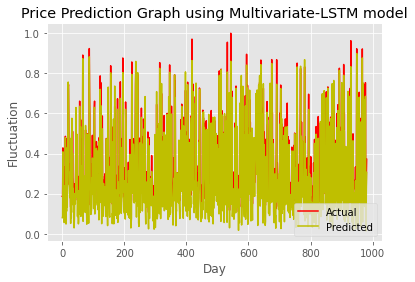

In [8]:
file_sentiment=f'./data/bert-base-cased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')
keys=df.columns
targets=['price']
model_name="ETH_BERT_base_cased_2_LSTM-7"

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)



In [9]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -79.95      -79.87   1.895e-35      -79.92
1       -104.9     -103.9*   2.709e-46     -104.5*
2       -104.9      -102.9   2.713e-46      -104.1
3       -105.0      -102.0   2.629e-46      -103.8
4       -104.8      -100.9   3.012e-46      -103.3
5       -104.8      -99.96   3.015e-46      -102.9
6       -105.1      -99.28   2.301e-46      -102.8
7      -105.2*      -98.43  2.063e-46*      -102.6
8       -105.1      -97.40   2.242e-46      -102.1
9       -105.1      -96.45   2.267e-46      -101.8
10      -105.2      -95.55   2.168e-46      -101.5
--------------------------------------------------


MSE = 0.0005147870975865923
RMSE = 0.022688920150297862
R-Squared Score = 0.9879656526337461


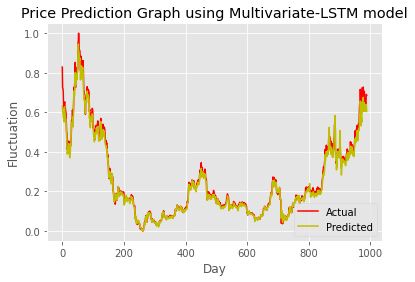

In [10]:
VAR_model_fitted1=VAR_model.fit(7)
df=df
keys=df.columns
model_name="VAR_BERT_base_cased"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+BERT_base_uncased


single layer LSTM train_l: 1.037056013349987e-05, val_l: 1.9026367134157056e-06
MSE = 0.012666700407862663
RMSE = 0.0
R-Squared Score = 0.6878551338823384


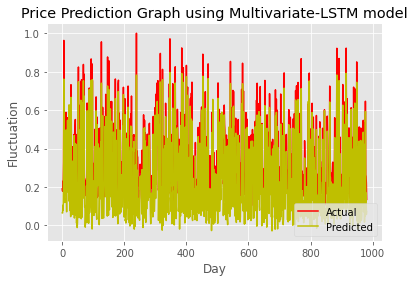

In [11]:
file_sentiment=f'./data/bert-base-uncased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']
model_name="ETH_BERT_base_uncased_2_LSTM-7"

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [12]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -80.80      -80.72   8.087e-36      -80.77
1       -105.8     -104.8*   1.129e-46     -105.4*
2       -105.7      -103.8   1.192e-46      -105.0
3       -105.7      -102.8   1.189e-46      -104.6
4       -105.7      -101.7   1.307e-46      -104.1
5       -105.6      -100.8   1.328e-46      -103.8
6       -105.9      -100.1   1.028e-46      -103.6
7      -105.9*      -99.14  1.015e-46*      -103.3
8       -105.9      -98.14   1.077e-46      -102.9
9       -105.9      -97.22   1.040e-46      -102.6
10      -105.9      -96.27   1.047e-46      -102.2
--------------------------------------------------


MSE = 0.0005318345297134654
RMSE = 0.02306153788699846
R-Squared Score = 0.9875671292036151


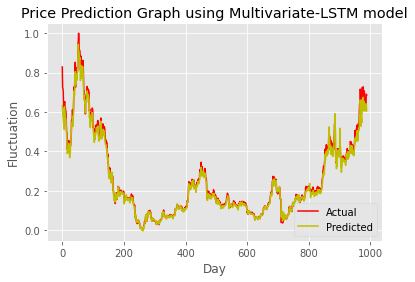

In [13]:
VAR_model_fitted1=VAR_model.fit(7)
df=df
keys=df.columns
model_name="VAR_BERT_base_uncased"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+BERT_large_cased


single layer LSTM train_l: 1.0772595282553768e-05, val_l: 3.045929697250781e-06
MSE = 0.01201972458511591
RMSE = 0.0
R-Squared Score = 0.7043739213983112


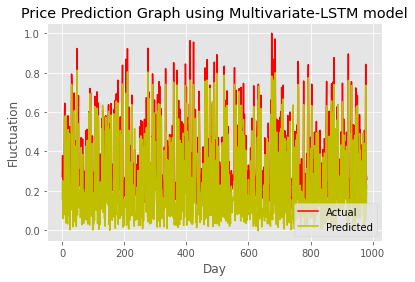

In [14]:
file_sentiment=f'./data/bert-large-cased_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']

model_name="ETH_BERT_large_cased_2_LSTM-7"

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [15]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -81.14      -81.06   5.757e-36      -81.11
1       -106.2     -105.1*   7.807e-47     -105.8*
2       -106.1      -104.1   8.113e-47      -105.4
3       -106.1      -103.2   7.960e-47      -105.0
4       -106.0      -102.1   8.890e-47      -104.5
5       -106.1      -101.2   8.758e-47      -104.2
6      -106.3*      -100.5  6.866e-47*      -104.1
7       -106.3      -99.49   7.168e-47      -103.6
8       -106.2      -98.45   7.865e-47      -103.2
9       -106.2      -97.48   8.039e-47      -102.8
10      -106.1      -96.50   8.321e-47      -102.4
--------------------------------------------------


MSE = 0.0005011086109628969
RMSE = 0.022385455344104504
R-Squared Score = 0.9882854191163288


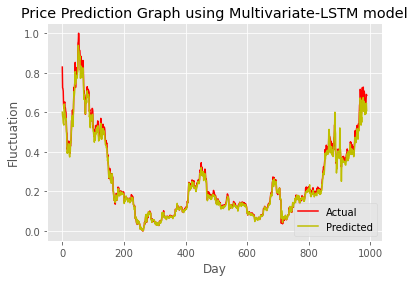

In [16]:
VAR_model_fitted1=VAR_model.fit(6)
df=df
keys=df.columns
model_name="VAR_BERT_large_cased"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+BERT_large_uncsed


single layer LSTM train_l: 1.2081925864997859e-05, val_l: 5.195109511025931e-06
MSE = 0.0074373409152030945
RMSE = 0.0
R-Squared Score = 0.8199064278641787


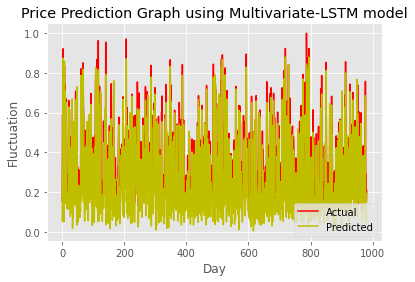

In [17]:
file_sentiment=f'./data/bert-large-uncased_sentiment.csv'

df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']

model_name="ETH_BERT_large_uncased_2_LSTM-7"
training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [18]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -80.95      -80.87   7.010e-36      -80.91
1       -105.9     -104.8*   1.044e-46     -105.5*
2       -105.8      -103.8   1.090e-46      -105.1
3       -105.9      -102.9   1.059e-46      -104.7
4       -105.8      -101.9   1.157e-46      -104.3
5       -105.7      -100.9   1.203e-46      -103.9
6       -106.0      -100.2   9.216e-47      -103.8
7      -106.0*      -99.25  9.111e-47*      -103.4
8       -106.0      -98.24   9.724e-47      -103.0
9       -106.0      -97.32   9.472e-47      -102.6
10      -106.0      -96.35   9.724e-47      -102.3
--------------------------------------------------


MSE = 0.0006496689636008197
RMSE = 0.02548860458324111
R-Squared Score = 0.9848124748702909


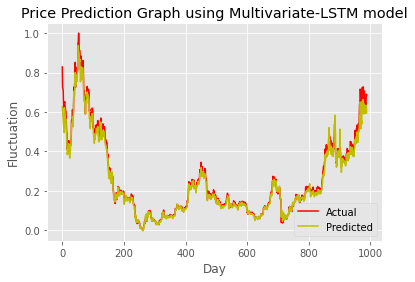

In [19]:
VAR_model_fitted1=VAR_model.fit(7)
df=df
keys=df.columns
model_name="VAR_BERT_large_uncased"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+RoBERTa_base


single layer LSTM train_l: 1.508847737146636e-05, val_l: 2.8652285953141325e-06
MSE = 0.007912226021289825
RMSE = 0.0
R-Squared Score = 0.796154827951689


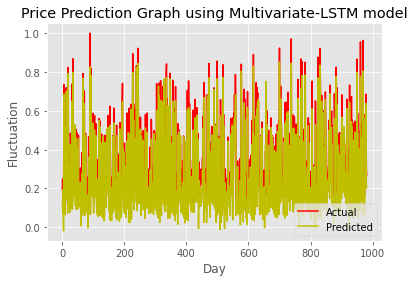

In [20]:
file_sentiment=f'./data/roberta_sentiment.csv'
model_name="ETH_RoBERTa_2_LSTM-7"

df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [21]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -80.20      -80.12   1.482e-35      -80.17
1       -105.2     -104.1*   2.149e-46     -104.8*
2       -105.2      -103.2   2.130e-46      -104.4
3       -105.2      -102.3   2.003e-46      -104.1
4       -105.1      -101.2   2.182e-46      -103.6
5       -105.2      -100.3   2.104e-46      -103.3
6       -105.4      -99.61   1.643e-46      -103.2
7      -105.5*      -98.75  1.511e-46*      -102.9
8       -105.4      -97.70   1.665e-46      -102.4
9       -105.4      -96.72   1.722e-46      -102.0
10      -105.4      -95.77   1.731e-46      -101.7
--------------------------------------------------


MSE = 0.0005313169740896547
RMSE = 0.0230503139694377
R-Squared Score = 0.9875792282717298


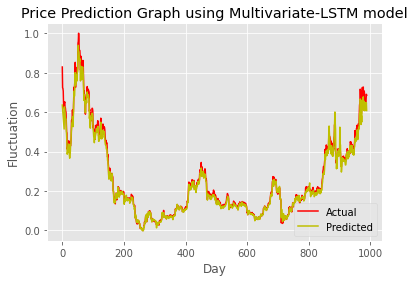

In [22]:
VAR_model_fitted1=VAR_model.fit(7)
df=df
keys=df.columns
model_name="VAR_RoBERTa"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM_RoBERTa_large


single layer LSTM train_l: 1.0781696641377335e-05, val_l: 2.9768949636920537e-06
MSE = 0.007826844230294228
RMSE = 0.0
R-Squared Score = 0.8034535131007362


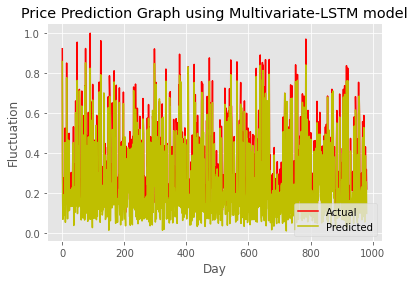

In [23]:
file_sentiment=f'./data/roberta-large_sentiment.csv'
model_name="ETH_RoBERTa-large_3_LSTM-7"

df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [24]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -79.60      -79.52   2.698e-35      -79.57
1       -104.7     -103.6*   3.536e-46     -104.3*
2       -104.7      -102.7   3.542e-46      -103.9
3       -104.7      -101.7   3.400e-46      -103.6
4       -104.6      -100.7   3.582e-46      -103.1
5       -104.7      -99.80   3.547e-46      -102.8
6       -105.0      -99.16   2.586e-46      -102.7
7      -105.1*      -98.29  2.377e-46*      -102.4
8       -105.0      -97.27   2.567e-46      -102.0
9       -105.0      -96.30   2.622e-46      -101.6
10      -105.1      -95.42   2.465e-46      -101.3
--------------------------------------------------


MSE = 0.0004538998936519873
RMSE = 0.0213049265113022
R-Squared Score = 0.9893890328345013


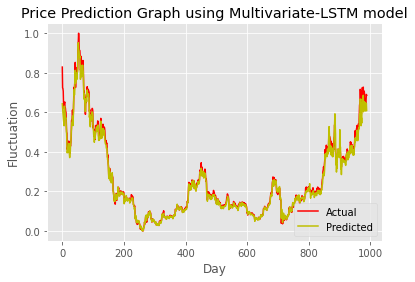

In [25]:
VAR_model_fitted1=VAR_model.fit(7)
df=df
keys=df.columns
model_name="VAR_RoBERTa_large"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+DistilBERT


single layer LSTM train_l: 1.0802565157591479e-05, val_l: 2.5388942440776143e-06
MSE = 0.008763709105551243
RMSE = 0.0
R-Squared Score = 0.8023140742248946


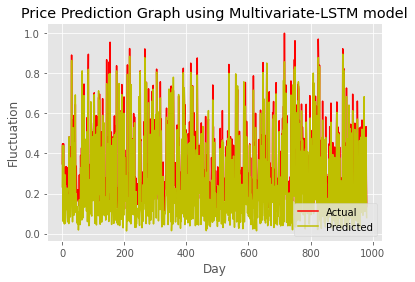

In [26]:
file_sentiment=f'./data/distilbert_sentiment.csv'
model_name="ETH_DistilBERT_2_LSTM-7"


df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [27]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -80.85      -80.77   7.736e-36      -80.82
1       -105.8     -104.8*   1.104e-46     -105.4*
2       -105.8      -103.8   1.167e-46      -105.0
3       -105.8      -102.8   1.149e-46      -104.6
4       -105.7      -101.8   1.274e-46      -104.2
5       -105.7      -100.8   1.291e-46      -103.8
6      -105.9*      -100.1  1.032e-46*      -103.6
7       -105.9      -99.09   1.067e-46      -103.2
8       -105.8      -98.05   1.170e-46      -102.8
9       -105.8      -97.16   1.115e-46      -102.5
10      -105.8      -96.17   1.160e-46      -102.1
--------------------------------------------------


MSE = 0.0004975168337606921
RMSE = 0.0223050853789151
R-Squared Score = 0.9883693852738261


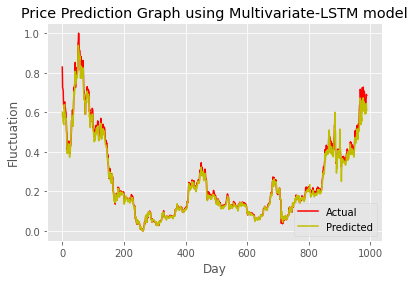

In [28]:
VAR_model_fitted1=VAR_model.fit(6)
df=df
keys=df.columns
model_name="VAR_DistilBERT"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## LSTM+FinBERT

single layer LSTM train_l: 9.186555122879867e-06, val_l: 8.670454724498012e-06
MSE = 0.009471253491938114
RMSE = 0.0
R-Squared Score = 0.7625182685047032


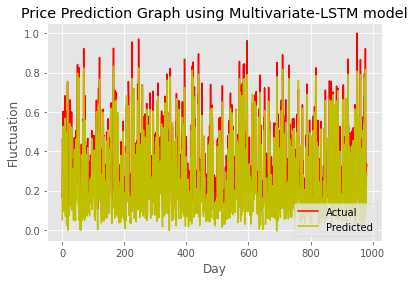

In [29]:
file_sentiment=f'./data/FinBert_pre_sentiment.csv'

model_name="ETH_FinBERT_2_LSTM-7"


df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
df=pd.concat([df[key], sentiment[['negative','positive']]], axis=1, join='inner')

targets=['price']

training_record,test_dataset=train_LSTM(model_name,df,keys,batch_size,targets,output_dim,seq_dim)
total_record,prediction_record=test_LSTM(model_name,test_dataset,training_record,total_record)
total_model_record= total_performance_LSTM(model_name,df,total_model_record,keys,batch_size,targets,output_dim,seq_dim,prediction_record,training_record)

In [30]:
from statsmodels.tsa.api import VAR
from VAR import *

tweets_mean = df["Marketcap"].mean()
df["Marketcap"] = df["Marketcap"].fillna(tweets_mean)
tweets_mean = df["tweets"].mean()
df["tweets"] = df["tweets"].fillna(tweets_mean)
targets = df["price"]
df=df[keys][:-1]
split = int(0.7 * len(df))
train_dataset = df[0: split - 1]
test_dataset = df[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled_train = scaler.fit_transform(train_dataset.values)
train_dataset = pd.DataFrame(df_scaled_train,columns=keys)
df_scaled_test = scaler.fit_transform(test_dataset.values)
test_dataset = pd.DataFrame(df_scaled_test,columns=keys)

VAR_model = VAR(train_dataset)
maxlags = 10
val_model_lag_select=VAR_model.select_order(maxlags=maxlags)
print(val_model_lag_select.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -81.17      -81.09   5.580e-36      -81.14
1       -106.2     -105.2*   7.357e-47     -105.8*
2       -106.1      -104.2   7.982e-47      -105.4
3       -106.1      -103.2   8.079e-47      -105.0
4       -106.0      -102.1   9.030e-47      -104.5
5       -106.0      -101.1   9.480e-47      -104.1
6       -106.2      -100.4   7.410e-47      -104.0
7      -106.3*      -99.48  7.241e-47*      -103.6
8       -106.2      -98.42   8.102e-47      -103.2
9       -106.1      -97.44   8.375e-47      -102.8
10      -106.1      -96.45   8.741e-47      -102.4
--------------------------------------------------


MSE = 0.0006030503680030591
RMSE = 0.0245570838660265
R-Squared Score = 0.9859022931190009


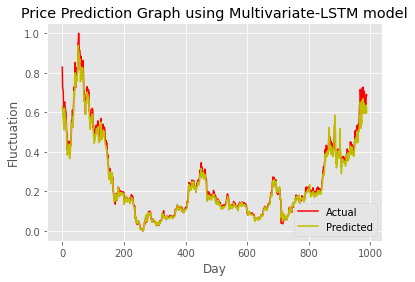

In [31]:
VAR_model_fitted1=VAR_model.fit(7)
df=df
keys=df.columns
model_name="VAR_FinBERT"
total_record,total_model_record=VAR_pre(model_name,VAR_model_fitted1,test_dataset,total_record,df,keys,total_model_record)

## result

In [34]:
##test dataset 
total_record["RMSE"]=np.sqrt(total_record["MSE"])

total_record.sort_values(['model_name','MSE'], ascending=True,inplace=True)
total_record.groupby("model_name").head(10).groupby("model_name").mean()

,MSE,RMSE,R2
model_name,,,
ETH_BERT_base_cased_2_LSTM-7,0.016518,0.128346,0.687567
ETH_BERT_base_uncased_2_LSTM-7,0.008309,0.090419,0.836004
ETH_BERT_large_cased_2_LSTM-7,0.009841,0.098624,0.805435
ETH_BERT_large_uncased_2_LSTM-7,0.007085,0.083337,0.860746
ETH_DistilBERT_2_LSTM-7,0.008283,0.089789,0.835730
ETH_FinBERT_2_LSTM-7,0.013650,0.116635,0.722913
ETH_LM_2_LSTM-7,0.006050,0.076816,0.854858
ETH_RoBERTa-large_3_LSTM-7,0.011661,0.107871,0.781970
ETH_RoBERTa_2_LSTM-7,0.006711,0.081308,0.860544


In [32]:
total_record["RMSE"]=np.sqrt(total_record["MSE"])

total_record.groupby("model_name").min("MSE").sort_values(["model_name","MSE"])

,MSE,RMSE,R2
model_name,,,
ETH_BERT_base_cased_2_LSTM-7,0.012662,0.112524,-0.391947
ETH_BERT_base_uncased_2_LSTM-7,0.004173,0.064595,-2.150646
ETH_BERT_large_cased_2_LSTM-7,0.005334,0.073033,-1.411860
ETH_BERT_large_uncased_2_LSTM-7,0.003113,0.055794,-1.505090
ETH_DistilBERT_2_LSTM-7,0.003367,0.058027,-3.526343
ETH_FinBERT_2_LSTM-7,0.009838,0.099189,-0.676672
ETH_LM_2_LSTM-7,0.002829,0.053187,-0.865510
ETH_RoBERTa-large_3_LSTM-7,0.009873,0.099363,-0.951572
ETH_RoBERTa_2_LSTM-7,0.004310,0.065649,-1.180830


In [33]:
total_model_record["RMSE"]=np.sqrt(total_model_record["MSE"])
total_model_record.sort_values("model")

,MSE,R2,RMSE,model,score,sentiment_method
2,0.005111,0.881073,0.071492,ETH_BERT_base_cased_2_LSTM-7,MSE,no sentiment
4,0.012667,0.687855,0.112546,ETH_BERT_base_uncased_2_LSTM-7,MSE,no sentiment
6,0.012020,0.704374,0.109635,ETH_BERT_large_cased_2_LSTM-7,MSE,no sentiment
8,0.007437,0.819906,0.086240,ETH_BERT_large_uncased_2_LSTM-7,MSE,no sentiment
14,0.008764,0.802314,0.093615,ETH_DistilBERT_2_LSTM-7,MSE,no sentiment
16,0.009471,0.762518,0.097320,ETH_FinBERT_2_LSTM-7,MSE,no sentiment
0,0.006233,0.857870,0.078948,ETH_LM_2_LSTM-7,MSE,no sentiment
12,0.007827,0.803454,0.088469,ETH_RoBERTa-large_3_LSTM-7,MSE,no sentiment
10,0.007912,0.796155,0.088951,ETH_RoBERTa_2_LSTM-7,MSE,no sentiment
3,0.000515,0.987966,0.022689,VAR_BERT_base_cased,MSE,no sentiment
